In [1]:
import numpy as np
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12506 (\N{KATAKANA LETTER PE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20808 (\N{CJK UNIFIED IDEOGRAPH-5148}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12458 (\N{KATAKANA LETTER O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anacon

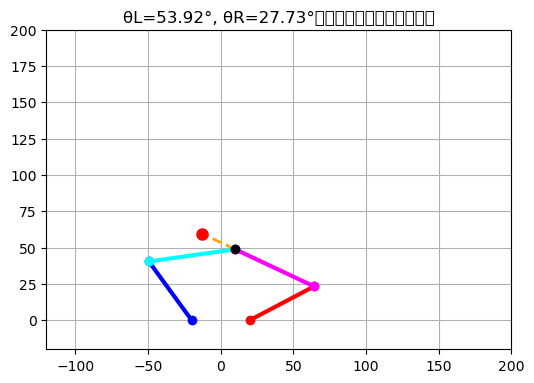

In [5]:
def plot_full_arm(theta_l_deg, theta_r_deg, l1=50, l2=60, d=40):
    """
    θ_l, θ_r から第一リンクと第二リンクを描写する統合関数。

    さらに：
    - 第二リンク交点 P（あなたの元コードの P[0], P[1]）
    - その P から右上側の腕（R_tip→P）の延長線上に 25mm だけ先にある
      「実際のペン先 P_tip」
    を描画します。
    """

    # --- 第一リンクの先端を取得 ---
    L_tip, R_tip = compute_first_link(theta_l_deg, theta_r_deg, l1=l1, d=d)
    if L_tip is None:
        return

    # --- 第二リンクの交点（元々のペン位置 P） ---
    P = compute_pen_position(L_tip, R_tip, l2)
    if P is None:
        return

    # --- 右側の「上側の第二リンク」方向に25mm延長して実ペン位置を求める ---
    OFFSET = 25.0  # mm (ここを変えれば任意の長さに調整可能)

    # 方向ベクトル（R_tip → P）
    dir_vec = P - R_tip
    norm = np.hypot(dir_vec[0], dir_vec[1])
    if norm < 1e-8:
        print("❌ ERROR: R_tip と P がほぼ同じ位置で、方向が定まりません")
        return

    unit_vec = dir_vec / norm

    # P からさらに 25mm 先の点（実際のペン先）
    P_tip = P + unit_vec * OFFSET

    # --- 描画開始 ---
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
    ax.set_aspect("equal")
    ax.set_xlim(-120, 200)
    ax.set_ylim(-20, 200)
    ax.grid(True)

    M_L = np.array([-d/2, 0.0])
    M_R = np.array([ d/2, 0.0])

    # 第一リンク
    ax.plot([M_L[0], L_tip[0]], [M_L[1], L_tip[1]], "o-", lw=3, color="blue")
    ax.plot([M_R[0], R_tip[0]], [M_R[1], R_tip[1]], "o-", lw=3, color="red")

    # 第二リンク（交点 P まで）※元のまま
    ax.plot([L_tip[0], P[0]], [L_tip[1], P[1]], "o-", lw=3, color="cyan")
    ax.plot([R_tip[0], P[0]], [R_tip[1], P[1]], "o-", lw=3, color="magenta")

    # P → P_tip の「延長部分」（ペン先オフセット）
    ax.plot([P[0], P_tip[0]], [P[1], P_tip[1]], "--", lw=2, color="orange")

    # 交点 P（関節位置）と 実ペン位置 P_tip
    ax.plot(P[0], P[1], "ko", markersize=6)       # 関節位置
    ax.plot(P_tip[0], P_tip[1], "ro", markersize=8)  # 実際のペン先

    plt.title(f"θL={theta_l_deg}°, θR={theta_r_deg}°（ペン先オフセット付き）")
    plt.show()


plot_full_arm(53.92, 27.73, l1=50, l2=60, d=40)



In [2]:
#組み込みよう


import numpy as np
import matplotlib.pyplot as plt

def plot_full_arm(theta_l_deg, theta_r_deg, l1=50, l2=60, d=40, offset=25, plot=True):
    """
    不可能な角度は None を返す
    """

    # --- ① 角度制限チェック（追加） ---
    if abs(theta_l_deg) > 180 or abs(theta_r_deg) > 180:
        # 不可能姿勢 → None を返す
        return None

    # --- 第一リンクの先端を取得 ---
    L_tip, R_tip = compute_first_link(theta_l_deg, theta_r_deg, l1=l1, d=d)
    if L_tip is None or R_tip is None:
        return None

    # --- 第二リンクの交点（元々のペン位置 P） ---
    P = compute_pen_position(L_tip, R_tip, l2)
    if P is None:
        return None

    # --- 実ペン先（25mm延長） ---
    dir_vec = P - R_tip
    norm = np.hypot(dir_vec[0], dir_vec[1])
    if norm < 1e-8:
        return None

    unit_vec = dir_vec / norm
    P_tip = P + unit_vec * offset

    # --- 描画（オプション） ---
    if plot:
        plt.figure(figsize=(6, 6))
        ax = plt.gca()
        ax.set_aspect("equal")
        ax.set_xlim(-120, 200)
        ax.set_ylim(-20, 200)
        ax.grid(True)

        M_L = np.array([-d/2, 0.0])
        M_R = np.array([ d/2, 0.0])

        ax.plot([M_L[0], L_tip[0]], [M_L[1], L_tip[1]], "o-", lw=3, color="blue")
        ax.plot([M_R[0], R_tip[0]], [M_R[1], R_tip[1]], "o-", lw=3, color="red")

        ax.plot([L_tip[0], P[0]], [L_tip[1], P[1]], "o-", lw=3, color="cyan")
        ax.plot([R_tip[0], P[0]], [R_tip[1], P[1]], "o-", lw=3, color="magenta")

        ax.plot([P[0], P_tip[0]], [P[1], P_tip[1]], "--", lw=2, color="orange")

        ax.plot(P[0], P[1], "ko", markersize=6)
        ax.plot(P_tip[0], P_tip[1], "ro", markersize=8)

        plt.title(f"θL={theta_l_deg}°, θR={theta_r_deg}°（offset={offset}mm）")
        plt.show()

    return P_tip, P, L_tip, R_tip
a = plot_full_arm(4017.90, 246.77, l1=65, l2=85, d=50, offset=25, plot=True)
print(a)

None


In [23]:
#組み込みの下請け関数
def point_segment_distance(P, A, B):
    """
    点P と 線分AB の最短距離
    """
    AP = P - A
    AB = B - A
    t = np.dot(AP, AB) / np.dot(AB, AB)

    t = np.clip(t, 0.0, 1.0)
    closest = A + t * AB
    return np.linalg.norm(P - closest)

def check_interference(L_tip, R_tip, P, d, threshold=1.0):
    """
    物理干渉があれば True を返す
    threshold(mm)：許容距離
    """

    M_L = np.array([-d/2, 0.0])
    M_R = np.array([ d/2, 0.0])

    # ---- ① モーター軸 と 第一リンク ----
    if point_segment_distance(M_L, M_L, L_tip) < threshold:
        return True
    if point_segment_distance(M_R, M_R, R_tip) < threshold:
        return True

    # ---- ② モーター軸 と 第二リンク ----
    if point_segment_distance(M_L, L_tip, P) < threshold:
        return True
    if point_segment_distance(M_R, R_tip, P) < threshold:
        return True

    # ---- ③ 第一リンク同士の交差 ----
    if segments_intersect(M_L, L_tip, M_R, R_tip):
        return True

    # ---- ④ 第二リンク同士の交差（異常形状）----
    if segments_intersect(L_tip, P, R_tip, P):
        return True

    return False


ToGPT
## 一本目の腕
うまくいっていません。一旦順運動学のコードを完璧に仕上げます。私の指示したコードを書いてください。関数としてθ_l,θ_rを受け取る。関数内にl_1(両方の第一関節までの腕の長さ)、d(モーター間距離)を準備する。モーターを(-d/2,0),(d/2,0)に配置、(-d/2,0)のモーターについては(-d/2,0)から((-l_1cosθ_l) - d/2,l_1sinθ_l)までを１番目の腕とする,(d/2,0)から((l_1cosθ_r) + d/2,l_1sinθ_r)までを二本目の腕とする。これをmatplotlibで描写する。2本の腕がd_minよりも近くなってしまう角度が設定されてしまった場合、printでエラーを出して。

このコードに改良を求める。2本の腕がd_minよりも近くなってしまう角度が設定されてしまった場合、printでエラーを出して。このアルゴリズムを変更して、
    # --- 距離チェック ---
    tip_dist = np.linalg.norm(L_tip - R_tip)
    if tip_dist < d_min:
        print(f"❌ ERROR: 先端距離 {tip_dist:.2f} mm < d_min {d_min} mm")
        return
を(180-θl)>θ_r　 + th_minでなければprintでエラー　出力部はここだけでいい

不自然な原因がわかりました。どちらかのアーム180度以上回った時により厳しい基準で判定する様にして(あなたの出力は変更箇所だけで良い)

θ_l,θ_rについて180度以上に回っちゃダメと言う制限を追加、回った場合はエラーを起こす、して、

## 2本目の腕
2本目の腕の作成に移ります。関数にl_2を追加してください(左右に2本目の腕の長さです),simulate_single_linkで求めた両腕の先からペンまでの腕を描写するコードを書いてください。ペンでl_2の先が重なります。
アルゴリズムは任せますが、次のようなアルゴリズムはどうでしょうか？simulate_single_linkで求めた２つの腕の先から半径l_2の円を描く、
円が0点で重なる場合、
腕がちぎれていると判定し、エラーをprintで出す
円が一点で重なる場合
そこが二つのl_2が交わるところ(ペンの位置)とする
円が２点で重なる場合
y座標が上に来るものがペンの位置にする

これ以外のアルゴリズムを採用する場合はコードを書かず、私に数式で説明してください。
このアルゴリズムを採用する場合は、simulate_single_linkを適切な名前、内容(pltの部分は全部いらないよね)に直した後、2本目の腕の作成から呼び出す感じで使ってください。(関数を一つにまとめないこと)

2本目の腕にはpltする機能をつけてくださいよ
2本目の腕を求める関数からpltする機能を省いてください。その代わり、角度を与えると1本目と2本目のうでを描写する関数を呼び出して、二つを書く関数を新たに書いてください

In [35]:
def ik_candidates(x, y, l1=50.0, l2=60.0, d=40.0):
    """
    ペン先位置 (x, y) を与えると
    左右の角度候補 (θL, θR) の組み合わせを返す。
    角度制限・干渉チェックはここでは行わない（純粋に候補だけ）。
    """

    candidates = []

    # =======================================
    #  左側アーム（θL）の候補を求める
    # =======================================
    XL = x + d/2
    YL = y
    rL = np.hypot(XL, YL)

    # K_L の計算
    KL = (l2**2 - l1**2 - rL**2) / (2 * l1)

    left_solutions = []
    if abs(KL / rL) <= 1.0:
        deltaL = np.arctan2(-YL, XL)
        phiL = np.arccos(KL / rL)

        # 2解
        left_solutions.append(deltaL + phiL)
        left_solutions.append(deltaL - phiL)
    else:
        # 解なし
        return []

    # ラジアン→度
    left_solutions = [np.degrees(t) for t in left_solutions]


    # =======================================
    #  右側アーム（θR）の候補を求める
    # =======================================
    XR = x - d/2
    YR = y
    rR = np.hypot(XR, YR)

    # K_R の計算
    KR = (l1**2 + rR**2 - l2**2) / (2 * l1)

    right_solutions = []
    if abs(KR / rR) <= 1.0:
        deltaR = np.arctan2(YR, XR)
        phiR = np.arccos(KR / rR)

        # 2解
        right_solutions.append(deltaR + phiR)
        right_solutions.append(deltaR - phiR)
    else:
        # 解なし
        return []

    # ラジアン→度
    right_solutions = [np.degrees(t) for t in right_solutions]


    # =======================================
    #  左2解 × 右2解 の最大4組を返す
    # =======================================
    for thL in left_solutions:
        for thR in right_solutions:
            candidates.append( (thL, thR) )

    return candidates


cands = ik_candidates(10, 60, l1=50, l2=60, d=40)

for thL, thR in cands:
    print(f"θL={thL:.2f}°, θR={thR:.2f}°")

θL=57.02°, θR=164.16°
θL=57.02°, θR=34.77°
θL=-183.89°, θR=164.16°
θL=-183.89°, θR=34.77°


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# ============================================================
#  FK-1 : 第一リンク（l1）先端座標を求める
# ============================================================
def compute_first_link(theta_l_deg, theta_r_deg, l1=50.0, d=40.0, theta_min=10.0):
    tl = np.radians(theta_l_deg)
    tr = np.radians(theta_r_deg)

    M_L = np.array([-d/2, 0.0])
    M_R = np.array([ d/2, 0.0])

    L_tip = np.array([
        M_L[0] - l1 * np.cos(tl),
        M_L[1] + l1 * np.sin(tl)
    ])

    R_tip = np.array([
        M_R[0] + l1 * np.cos(tr),
        M_R[1] + l1 * np.sin(tr)
    ])

    return L_tip, R_tip


# ============================================================
#  FK-2 : 第二リンクの交点（基準点 P）
# ============================================================
def compute_pen_position(L_tip, R_tip, l2):
    x1, y1 = L_tip
    x2, y2 = R_tip
    d = np.hypot(x2 - x1, y2 - y1)

    if d > 2*l2:
        return None

    a = d/2
    h = np.sqrt(l2**2 - a*a)

    xm = x1 + (x2-x1)*a/d
    ym = y1 + (y2-y1)*a/d

    rx = -(y2 - y1) * (h/d)
    ry =  (x2 - x1) * (h/d)

    p1 = np.array([xm + rx, ym + ry])
    p2 = np.array([xm - rx, ym - ry])

    return p1 if p1[1] >= p2[1] else p2


# ============================================================
#  FK-3 ：ペン先（25mm延長した実ペン先）
# ============================================================
def forward_pen_tip(theta_l_deg, theta_r_deg, l1=50.0, l2=60.0, d=40.0, offset=25.0):
    L_tip, R_tip = compute_first_link(theta_l_deg, theta_r_deg, l1=l1, d=d)
    P = compute_pen_position(L_tip, R_tip, l2)
    if P is None:
        return None

    dir_vec = P - R_tip
    norm = np.hypot(dir_vec[0], dir_vec[1])
    if norm < 1e-6:
        return None

    unit_vec = dir_vec / norm
    P_tip = P + unit_vec * offset
    return P_tip


# ============================================================
#  IK 初期値：第二リンク交点を目標として解く（通常の5bar IK）
# ============================================================
def ik_candidates(Px, Py, l1=50.0, l2=60.0, d=40.0):
    cands = []

    # 左側
    XL = Px + d/2
    YL = Py
    rL = np.hypot(XL, YL)
    cos_L = (l1*l1 + rL*rL - l2*l2) / (2*l1*rL)
    if abs(cos_L) > 1:
        return []
    baseL = np.arctan2(YL, XL)
    phiL = np.arccos(cos_L)
    left = [baseL + phiL, baseL - phiL]

    # 右側
    XR = Px - d/2
    YR = Py
    rR = np.hypot(XR, YR)
    cos_R = (l1*l1 + rR*rR - l2*l2) / (2*l1*rR)
    if abs(cos_R) > 1:
        return []
    baseR = np.arctan2(YR, XR)
    phiR = np.arccos(cos_R)
    right = [baseR + phiR, baseR - phiR]

    # 4組
    for tL in left:
        for tR in right:
            cands.append((np.degrees(tL), np.degrees(tR)))

    return cands


# ============================================================
#  IK 微調整（ニュートン法でペン先を合わせる）
# ============================================================
def refine_ik_to_pen_tip(
    target_x, target_y,
    theta_l_init_deg, theta_r_init_deg,
    l1=50.0, l2=60.0, d=40.0, offset=25.0,
    max_iter=20, tol=1e-3
):
    thL = theta_l_init_deg
    thR = theta_r_init_deg

    for _ in range(max_iter):
        P_tip = forward_pen_tip(thL, thR, l1=l1, l2=l2, d=d, offset=offset)
        if P_tip is None:
            return None

        err = P_tip - np.array([target_x, target_y])
        if np.linalg.norm(err) < tol:
            return thL, thR

        eps = 1e-3
        J = np.zeros((2, 2))

        # θL
        P_L = forward_pen_tip(thL + eps, thR, l1=l1, l2=l2, d=d, offset=offset)
        if P_L is None:
            return None
        J[:,0] = (P_L - P_tip) / eps

        # θR
        P_R = forward_pen_tip(thL, thR + eps, l1=l1, l2=l2, d=d, offset=offset)
        if P_R is None:
            return None
        J[:,1] = (P_R - P_tip) / eps

        try:
            delta = np.linalg.solve(J, -err)
        except np.linalg.LinAlgError:
            return None

        thL += delta[0]
        thR += delta[1]

    return None


# ============================================================
#  🧩 ペン先 (x, y) の IK を最終的に返す関数
# ============================================================
def ik_pen_tip(x, y, l1=50.0, l2=60.0, d=40.0, offset=25.0):
    results = []
    # ① 交点 P と仮定してIK（初期値）
    raw = ik_candidates(x, y, l1=l1, l2=l2, d=d)
    for thL0, thR0 in raw:
        # ② ペン先に合うようにニュートン法で微調整
        refined = refine_ik_to_pen_tip(
            x, y,
            thL0, thR0,
            l1=l1, l2=l2, d=d, offset=offset
        )
        if refined is not None:
            results.append(refined)

    return results


# ============================================================
#  📌 動作テスト
# ============================================================
if __name__ == "__main__":
    x, y = 8.635,38.641   # ペン先のターゲット

    sols = ik_pen_tip(x, y, l1=50, l2=60, d=40, offset=25)

    print("=== Solutions ===")
    for thL, thR in sols:
        P = forward_pen_tip(thL, thR)
        print(f"θL={thL:.2f}, θR={thR:.2f} → P_tip={P}")


=== Solutions ===
θL=4017.90, θR=246.77 → P_tip=[ 8.63500209 38.6409971 ]


次に逆運動学を考えます。一旦コードを一切書かず、どの様な計算をすればx,yから二つのモーター角度を割り出せるかを導き方も合わせて数式で書いてみてください。
特に問題なさそうなので、あなたが言ったアルゴリズムを採用します。x,yを与えると、角度の候補の組みが出てくるコードを書いてください

togpt
リストfinal_curves(x,y座標が格納されている)を受け取って角度の情報を追加してreturnする関数genrad((listname, l1=50.0, l2=60.0, d=40.0, offset=25.0))
を書いてください。いかがgenradで使うといい関数です。
a = plot_full_arm(53.92, 27.73, l1=50, l2=60, d=40, offset=25, plot=False)
print(a)
53.92, 27.73,の様に角度を入れるとxyの座標を返してくれる。機構上できない角度にはNoneを返す。


    x, y = -12.655, 59.457    # ペン先のターゲット
以下は(x,y)から角度を求める例
    sols = ik_pen_tip(x, y, l1=50, l2=60, d=40, offset=25)

    print("=== Solutions ===")
    for thL, thR in sols:
        P = forward_pen_tip(thL, thR)
        print(f"θL={thL:.2f}, θR={thR:.2f} → P_tip={P}")

おそらくfor文のなかで角度を求めて、それをplot_full_armでチェック、いくつか機構上可能な角度が見つかったらリストの一つ前に導いた角度に最も近い角度を採用する。
というアルゴリズムにしたらいいと思います。